# import

In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.3 MB/s 


In [ ]:
import os
import argparse
import time
import random
import pickle

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import keras

from keras import losses
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold, StratifiedKFold

from keras import models
import segmentation_models as sm
from segmentation_models import get_preprocessing

# resnet 모델 사용
preprocess_input = get_preprocessing('resnet34')
#preprocess_input = get_preprocessing('resnet50')
preprocess_input

Segmentation Models: using `keras` framework.


<function classification_models.models.resnet.preprocess_input(x, **kwargs)>

# 1. 이미지 전처리 (horizontal, vertical, reflect)

In [ ]:
# Slide, Mask ImageDataGenerator
train_slide_datagen = ImageDataGenerator(#rescale= 1./255,
                                        width_shift_range=[-10, 10],
                                        rotation_range=90, 
                                        fill_mode='reflect',
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        preprocessing_function=preprocess_input)

train_mask_datagen = ImageDataGenerator(rescale= 1./255,
                                        width_shift_range=[-10, 10],
                                        rotation_range=90,
                                        fill_mode='reflect',
                                        horizontal_flip=True,
                                        vertical_flip=True)

valid_slide_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)# rescale= 1./255
valid_mask_datagen = ImageDataGenerator(rescale= 1./255)

# 2. 옵티마이저 설정

In [ ]:
from keras.optimizers import Adam

"""
Network Architecture
"""

def fpn(backbone, pretrained_weights=None):
    model = sm.FPN(backbone, 
                   input_shape=(256, 256, 3), 
                   classes=1, 
                   activation='sigmoid', 
                   encoder_weights=pretrained_weights)
    
    model.compile(optimizer='adam', 
                  loss=sm.losses.bce_jaccard_loss, 
                  metrics=[sm.metrics.iou_score, sm.metrics.f1_score])
    return model

model = fpn(backbone='resnet34', pretrained_weights='imagenet') # pretrained 가중치 적용
#model = fpn(backbone='resnet50', pretrained_weights='imagenet')

85521592/85521592 [==============================] - 13s 0us/step


# 3. K-fold generator

In [ ]:
def kfold_data_generator(slide_datagen, mask_datagen, df, batch_size=32, seed=42):
    slide_generator = \
        slide_datagen.flow_from_dataframe(df,
                                          x_col='slide_path',
                                          y_col='mask_path',
                                          seed=seed,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          class_mode=None)

    mask_generator = \
        mask_datagen.flow_from_dataframe(df,
                                         x_col='mask_path',
                                         y_col='mask_path',
                                         color_mode='grayscale',
                                         seed=seed,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         class_mode=None)
    
    
    generator = zip(slide_generator, mask_generator)
    for (slide, mask) in generator:
        mask = mask
        yield slide, mask

# 4. 전체 패치이미지 경로 데이터 불러오기

- 암인 부분 : 암이 아닌 부분 = 1 : 2로 맞추기

In [ ]:
img_mask_pairs_path = './patches/img_mask_pairs/img_mask_whole_pairs.pkl'

with open(img_mask_pairs_path, 'rb') as f:
  img_mask_pairs = pickle.load(f)
all_patches_sample = pd.DataFrame(img_mask_pairs, columns=['slide_path', 'mask_path'])
all_patches_sample = all_patches_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# 종양인 부분 
is_tumor_patches_samples = all_patches_sample[all_patches_sample['mask_path'] != '-.png']

# 종양이 아닌 부분
is_not_tumor_patches_samples = all_patches_sample[all_patches_sample['mask_path'] == '-.png']
is_not_tumor_patches_samples = is_not_tumor_patches_samples.sample(n = len(is_tumor_patches_samples)*2)

# 흰부분 추가
is_not_tumor_patches_samples['mask_path'] = './patches/mask/white.png'

total_df = pd.concat([is_tumor_patches_samples, is_not_tumor_patches_samples], axis = 0)

In [ ]:
total_df

,slide_path,mask_path
1,./patches/train/BC_01_0877/BC_01_0877_69.png,./patches/mask/BC_01_0877/BC_01_0877_69.png
6,./patches/train/BC_01_0902/BC_01_0902_46.png,./patches/mask/BC_01_0902/BC_01_0902_46.png
7,./patches/train/BC_01_0425/BC_01_0425_28.png,./patches/mask/BC_01_0425/BC_01_0425_28.png
10,./patches/train/BC_01_0928/BC_01_0928_8.png,./patches/mask/BC_01_0928/BC_01_0928_8.png
15,./patches/train/BC_01_0530/BC_01_0530_14.png,./patches/mask/BC_01_0530/BC_01_0530_14.png
...,...,...
2866,./patches/train/BC_01_0674/BC_01_0674_34.png,./patches/mask/white.png
2992,./patches/train/BC_01_0587/BC_01_0587_98.png,./patches/mask/white.png
301,./patches/train/BC_01_0974/BC_01_0974_67.png,./patches/mask/white.png
3357,./patches/train/BC_01_0587/BC_01_0587_91.png,./patches/mask/white.png


# 5. 모델 학습 및 훈련

In [ ]:
batch_size = 32
epochs = 30

n_kfold = 5
seed = 42
kf = KFold(n_splits=n_kfold, shuffle=True, random_state=seed)
folds = list(kf.split(total_df))

for f_idx, (train_idx, valid_idx) in enumerate(folds):
  print('*'*20, f'{f_idx}-Fold 학습 시작', '*'*20)
  train_df = total_df.iloc[train_idx]
  valid_df = total_df.iloc[valid_idx]

  # 사용자 함수 적용 (해당 경로에 있는 이미지 변환후 slide, mask로 반출)
  train_slide_mask_gen = kfold_data_generator(train_slide_datagen,
                                              train_mask_datagen,
                                              df=train_df,
                                              batch_size=batch_size,
                                              seed=seed)
  valid_slide_mask_gen = kfold_data_generator(valid_slide_datagen, 
                                              valid_mask_datagen, 
                                              df=valid_df,
                                              batch_size=batch_size,
                                              seed=batch_size)
  
  train_steps = len(train_df) // batch_size
  valid_steps = len(valid_df) // batch_size

  print(train_steps, valid_steps)

  callbacks_list = [
      ModelCheckpoint(
          filepath=f'./patches/models/1202_nonscale_doubleratio_resnet34_{f_idx+1}_fold_fpn_best_model.h5',
          monitor='iou_score',
          mode='max',
          save_best_only=True,
          verbose=1),
      ReduceLROnPlateau(
          monitor='iou_score',
          mode='max',
          factor=0.1,
          patience=3,
          verbose=1)]
  
  history = model.fit(train_slide_mask_gen,
                                steps_per_epoch = train_steps,
                                validation_data=valid_slide_mask_gen,
                                validation_steps=valid_steps,
                                epochs=epochs, verbose=1,
                                callbacks=callbacks_list)

******************** 0-Fold 학습 시작 ********************
57 14
Found 1840 validated image filenames.
Found 1840 validated image filenames.
Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 0.2118 - iou_score: 0.9210 - f1-score: 0.9534  Found 461 validated image filenames.
Found 461 validated image filenames.

Epoch 1: iou_score improved from -inf to 0.92102, saving model to ./patches/models/1202_nonscale_doubleratio_resnet34_1_fold_fpn_best_model.h5
57/57 [==============================] - 7650s 134s/step - loss: 0.2118 - iou_score: 0.9210 - f1-score: 0.9534 - val_loss: 0.5001 - val_iou_score: 0.9471 - val_f1-score: 0.9722 - lr: 0.0010
Epoch 2/30
57/57 [==============================] - ETA: 0s - loss: 0.1725 - iou_score: 0.9493 - f1-score: 0.9728  
Epoch 2: iou_score improved from 0.92102 to 0.94932, saving model to ./patches/models/1202_nonscale_doubleratio_resnet34_1_fold_fpn_best_model.h5
57/57 [==============================] - 7599s 135s/step - loss: 0.1725 - iou_

- 모델 저장

In [ ]:
model.save('./patches/models/1202_noscale_doubleratio_resnet34_fold_total_fpn_best_model.h5')

# 6. 모델적용 및 예측결과 확인

In [ ]:
# best모델 불러오기
best_model = models.load_model('./patches/models/1201_nonscale_sameratio_3_fold_fpn_best_model.h5',custom_objects={'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss,'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

- 불러올 이미지 경로

In [ ]:
import matplotlib.pyplot as plt
import cv2

mask_base_dir = './patches/mask/'
mask_file_dir = sorted(os.listdir(mask_base_dir))
mask_filenames = os.listdir(mask_base_dir+mask_file_dir[0])

train_base_dir = './patches/train/'
train_file_dir = sorted(os.listdir(train_base_dir))
train_filenames = os.listdir(train_base_dir+train_file_dir[0])

## 1) 예측값

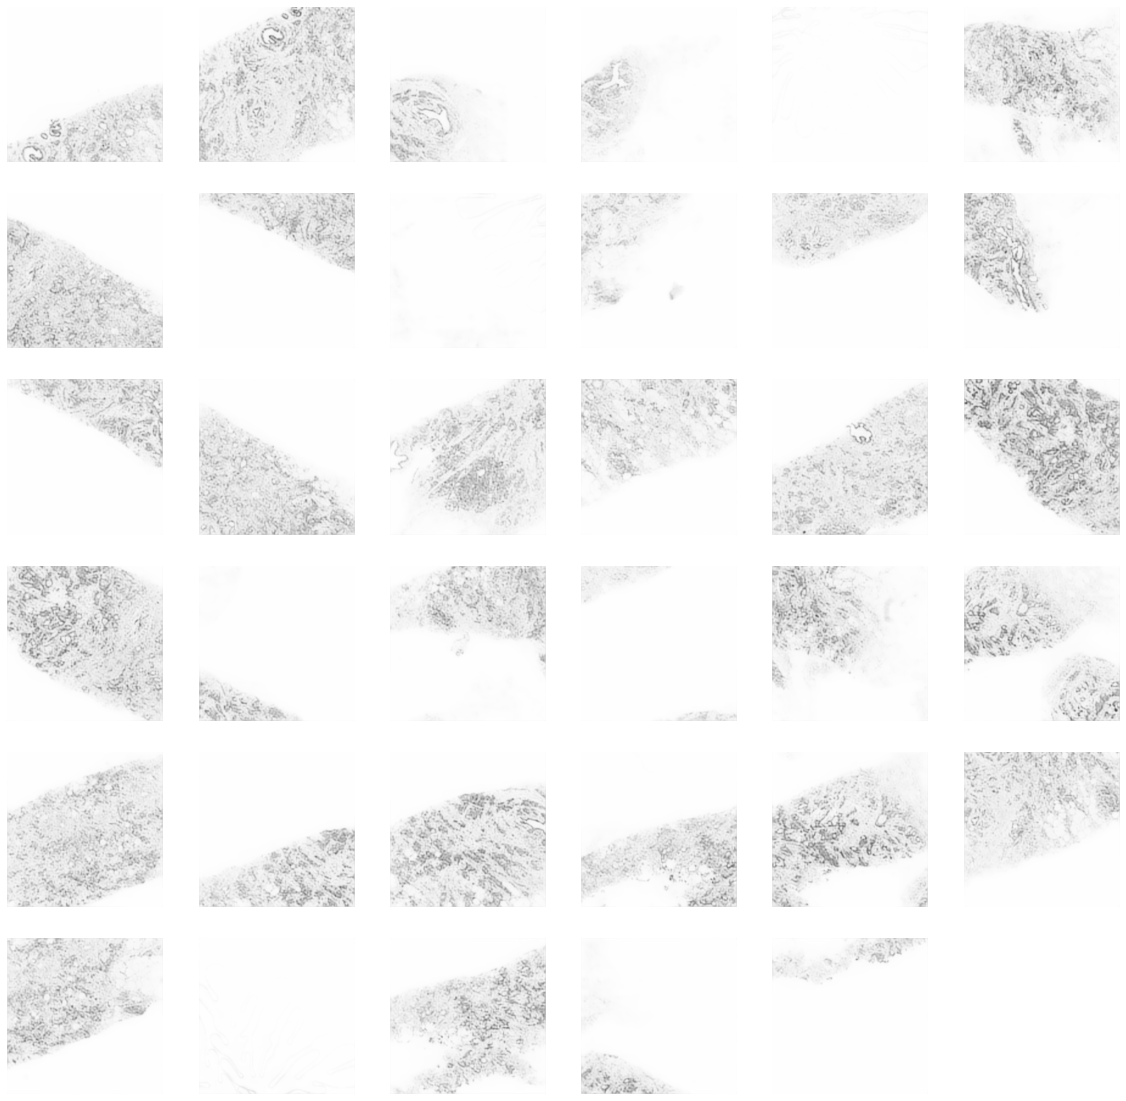

In [ ]:
# 원본예측
plt.figure(figsize = (20, 20))
for i, filename in enumerate(train_filenames): 
  ex = cv2.imread(train_base_dir + mask_file_dir[0] + '/' + filename)
  
  if ex is None:
    ex = cv2.imread('./patches/mask/white.png')

  preds = best_model.predict(ex[None, :, :, :], verbose = 0)

  plt.subplot(6, len(train_filenames)//6 + 1, i+1)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(preds[0], cv2.COLOR_GRAY2RGB))

plt.show()

## 2) 원본 이미지

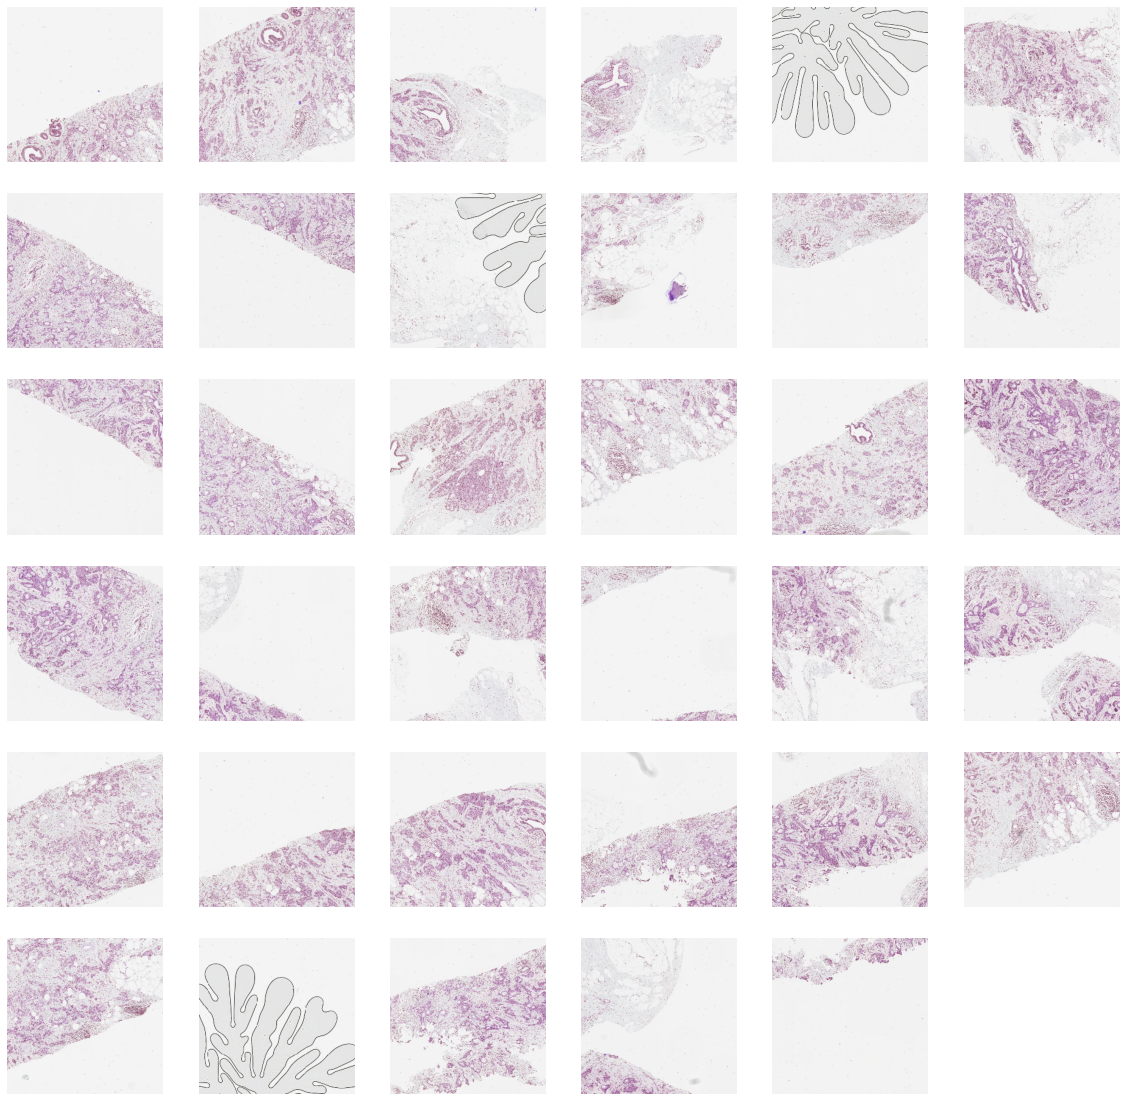

In [ ]:
# 원본
plt.figure(figsize = (20, 20))
for i, filename in enumerate(train_filenames): 
  ex = cv2.imread(train_base_dir + mask_file_dir[0] + '/' + filename)

  # preds = best_model.predict(ex[None, :, :, :], verbose = 0)

  plt.subplot(6, len(train_filenames)//6 + 1, i+1)
  plt.axis('off')
  plt.imshow(ex)

plt.show()

## 3) mask 된 원본 부분

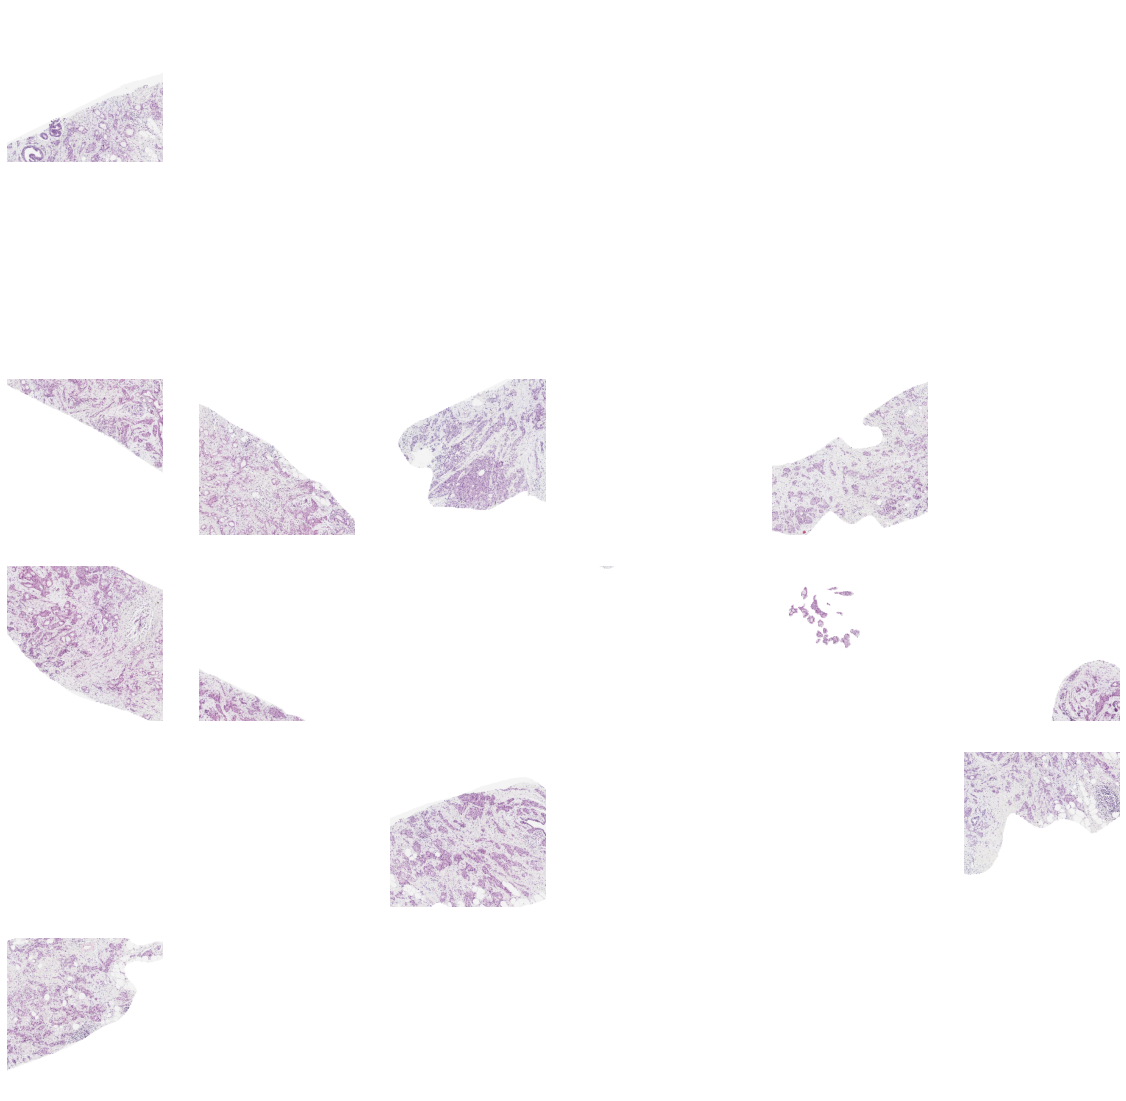

In [ ]:
# 마스크 원본
plt.figure(figsize = (20, 20))
for i, filename in enumerate(train_filenames): 
  ex = cv2.imread(mask_base_dir + mask_file_dir[0] + '/' + filename)

  if ex is None:
    ex = cv2.imread('./patches/mask/white.png')

  # preds = best_model.predict(ex[None, :, :, :], verbose = 0)

  plt.subplot(6, len(train_filenames)//6 + 1, i+1)
  plt.axis('off')
  plt.imshow(ex)

plt.show()